In [36]:
from tensorflow.keras.applications import VGG16
import tensorflow as tf
import numpy as np
import os
from PIL import Image
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

In [12]:
def vgg_model():
    model = VGG16(weights='imagenet', include_top=False)
    # Use output from last conv block
    int_model = tf.keras.Model(model.input, model.get_layer("block5_pool").output)
    return int_model

def preprocess_img(img_path, size=224):
    img = Image.open(img_path).convert("RGB")
    img = img.resize((size, size))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.keras.applications.vgg16.preprocess_input(img_array)
    return np.expand_dims(img_array, axis=0)  # (1, size, size, 3)

def extract_features(img_path, model, size=224):
    img_tensor = preprocess_img(img_path, size)
    features = model.predict(img_tensor)
    return features.flatten()

In [38]:
def load_feature_dataset(root_dir, model, size=224):
    X = []  # Feature sets
    y = []  # Labels (0, 1, 2, 3)
    trial_metadata = []

    for rule_type in os.listdir(root_dir):
        rule_path = os.path.join(root_dir, rule_type)
        if not os.path.isdir(rule_path): continue

        for rule_folder in os.listdir(rule_path):
            img_folder = os.path.join(rule_path, rule_folder)
            if not os.path.isdir(img_folder): continue

            img_paths = [
                os.path.join(img_folder, "inlier_0.png"),
                os.path.join(img_folder, "inlier_1.png"),
                os.path.join(img_folder, "inlier_2.png"),
                os.path.join(img_folder, "outlier.png")
            ]

            features = [extract_features(p, model, size) for p in img_paths]
            paired = list(zip(img_paths, features))
            np.random.shuffle(paired)

            shuffled_paths, shuffled_features = zip(*paired)
            shuffled_features = list(shuffled_features)

            # Find index of the outlier in shuffled list
            outlier_idx = [i for i, path in enumerate(shuffled_paths) if "outlier" in path][0]

            # Save for training
            X.append(shuffled_features)
            y.append(outlier_idx)

            # Save for later visualization
            trial_metadata.append({
                "rule": rule_type,
                "img_paths": shuffled_paths,
                "true_outlier_idx": outlier_idx,
            })

    return np.array(X), np.array(y), trial_metadata

In [39]:
model = vgg_model()
X, y, trial_metadata = load_feature_dataset("data", model, size=224)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━

In [40]:
# Flatten to a single vector
X_flat = X.reshape((X.shape[0], -1))

indices = np.arange(len(X))

# Train/test split
# X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42)
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)
X_train, X_test = X_flat[train_idx], X_flat[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

train_meta = [trial_metadata[i] for i in train_idx]
test_meta = [trial_metadata[i] for i in test_idx]

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Odd-one-out accuracy (RandomForest):", acc)

Odd-one-out accuracy (RandomForest): 0.2


In [41]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Odd-one-out accuracy (LogReg):", acc)

Odd-one-out accuracy (LogReg): 0.25


In [42]:
clf = MLPClassifier(hidden_layer_sizes=(128,), activation='relu', max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Odd-one-out accuracy (MLP):", acc)

Odd-one-out accuracy (MLP): 0.35


In [43]:
# To see correct vs incorrect trials
correct_mask = (y_pred == y_test)
incorrect_mask = ~correct_mask

correct_indices = np.where(correct_mask)[0]
incorrect_indices = np.where(incorrect_mask)[0]

for i in range(len(y_test)):
    meta = test_meta[i]
    print(f"Trial {i} — Rule: {meta['rule']}")
    print(f"  True outlier index: {y_test[i]}")
    print(f"  Predicted index:    {y_pred[i]}")
    for j, path in enumerate(meta["img_paths"]):
        print(f"    [{j}] {path}")
    print()

Trial 0 — Rule: two_nonintersecting_lines
  True outlier index: 1
  Predicted index:    0
    [0] data/two_nonintersecting_lines/rule_003/inlier_1.png
    [1] data/two_nonintersecting_lines/rule_003/outlier.png
    [2] data/two_nonintersecting_lines/rule_003/inlier_0.png
    [3] data/two_nonintersecting_lines/rule_003/inlier_2.png

Trial 1 — Rule: three_intersecting_lines
  True outlier index: 1
  Predicted index:    1
    [0] data/three_intersecting_lines/rule_003/inlier_0.png
    [1] data/three_intersecting_lines/rule_003/outlier.png
    [2] data/three_intersecting_lines/rule_003/inlier_1.png
    [3] data/three_intersecting_lines/rule_003/inlier_2.png

Trial 2 — Rule: two_circles_intersecting_line
  True outlier index: 3
  Predicted index:    0
    [0] data/two_circles_intersecting_line/rule_010/inlier_1.png
    [1] data/two_circles_intersecting_line/rule_010/inlier_0.png
    [2] data/two_circles_intersecting_line/rule_010/inlier_2.png
    [3] data/two_circles_intersecting_line/rule_

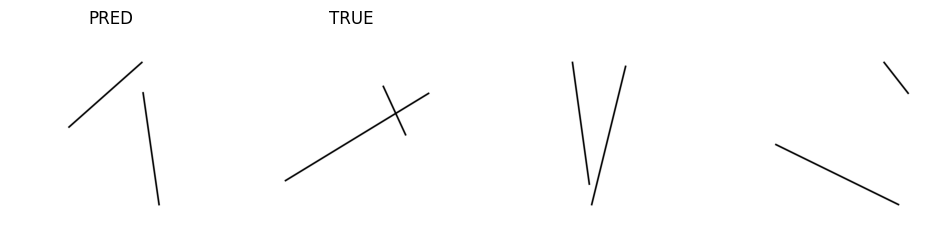

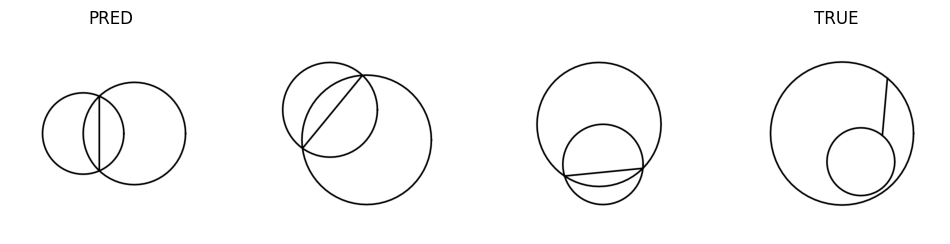

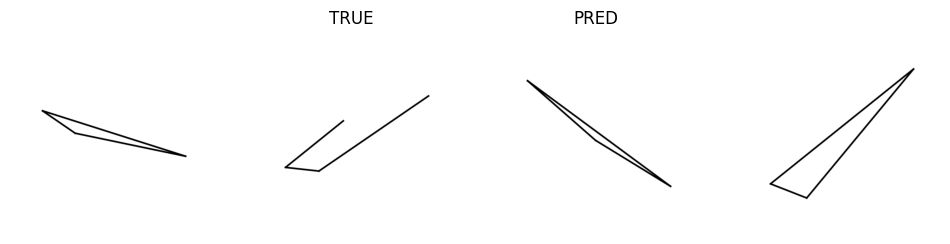

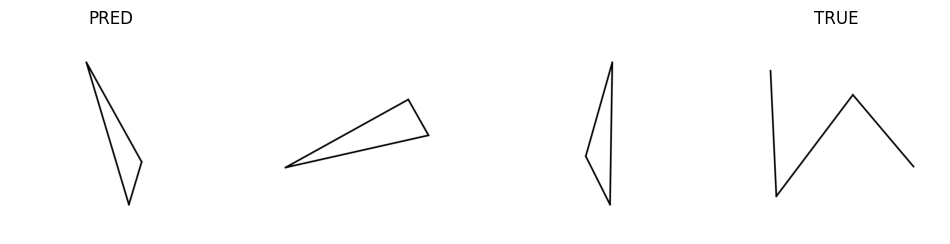

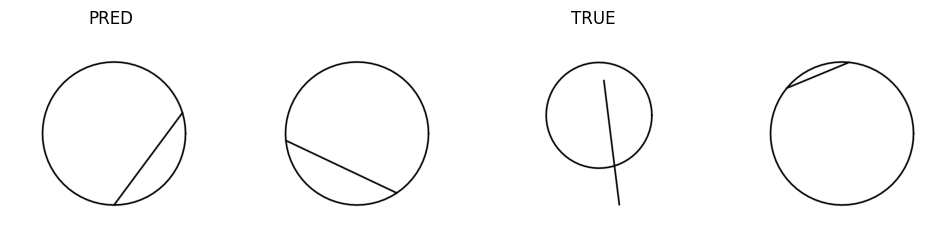

In [44]:
def visualize_trial(img_paths, true_idx, pred_idx):
    fig, axes = plt.subplots(1, 4, figsize=(12, 3))
    for i, ax in enumerate(axes):
        img = Image.open(img_paths[i])
        ax.imshow(img)
        ax.axis('off')
        title = ""
        if i == true_idx:
            title += "TRUE "
        if i == pred_idx:
            title += "PRED"
        ax.set_title(title)
    plt.show()

for i in np.where(y_pred != y_test)[0][:5]:
    meta = test_meta[i]
    visualize_trial(meta["img_paths"], y_test[i], y_pred[i])